linear_svm.py와 linear_classifier.py에 정의되어 있던 함수까지 이 노트에 포함했습니다.

# Multiclass Support Vector Machine exercise

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


## CIFAR-10 Data Loading and Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10  # 케라스가 이미 설치돼 있다면 간편하게 데이터를 가져올 수 있다.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Using TensorFlow backend.


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


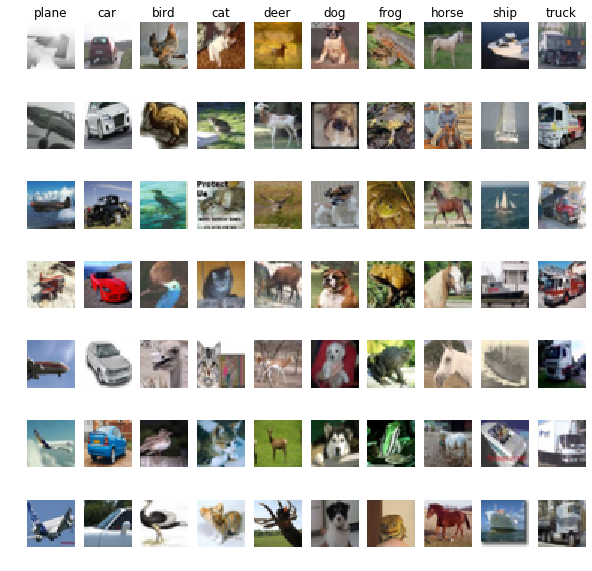

In [2]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask].astype('float64')
y_val = y_train[mask]

# Our training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask].astype('float64')
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask].astype('float64')
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask].astype('float64')
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


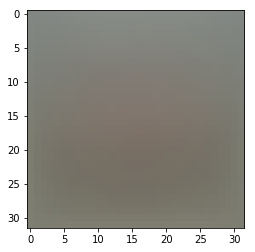

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM loss (naive)

In [6]:
def svm_loss_naive(W, X, y, reg): # reg: (float) regularization strength

    dW = np.zeros(W.shape) 
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:         # margin이 0보다 클 때에만 손실값(그리고 그레디언트)가 0보다 크다.
                loss += margin
                dW[:,j] += X[i]
                dW[:,y[i]] -= X[i]

    loss /= num_train
    loss += reg * np.sum(W * W)
    dW = (dW / num_train) + (2 * reg * W)
    
    return loss, dW

#### gradient check

In [7]:
from gradient_check import grad_check_sparse
W = np.random.randn(3073, 10) * 0.0001 

# 규제를 가하지 않았을 때
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -16.773389 analytic: -16.773389, relative error: 1.659939e-11
numerical: -9.248638 analytic: -9.248638, relative error: 9.275100e-12
numerical: 4.412718 analytic: 4.412718, relative error: 3.248278e-11
numerical: 11.369021 analytic: 11.369021, relative error: 1.155817e-11
numerical: -12.221811 analytic: -12.221811, relative error: 5.456692e-12
numerical: -19.748941 analytic: -19.748941, relative error: 7.488083e-12
numerical: -15.558764 analytic: -15.558764, relative error: 1.466016e-11
numerical: 28.225225 analytic: 28.225225, relative error: 1.089532e-12
numerical: 29.556353 analytic: 29.556353, relative error: 8.487478e-12
numerical: 22.418965 analytic: 22.418965, relative error: 4.767781e-12


In [8]:
# 규제를 가했을 때
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 12.996964 analytic: 12.996964, relative error: 3.745544e-11
numerical: -1.157448 analytic: -1.157448, relative error: 1.351770e-10
numerical: 23.028195 analytic: 23.028195, relative error: 7.262575e-12
numerical: -19.955279 analytic: -19.899444, relative error: 1.400965e-03
numerical: 3.695822 analytic: 3.695822, relative error: 1.496861e-10
numerical: -1.721276 analytic: -1.721276, relative error: 1.333404e-10
numerical: 28.230295 analytic: 28.230295, relative error: 1.004767e-11
numerical: -11.399846 analytic: -11.369676, relative error: 1.325016e-03
numerical: 16.220390 analytic: 16.220390, relative error: 1.401262e-11
numerical: 13.218147 analytic: 13.218147, relative error: 1.036741e-11


SVM loss function은 미분가능하지 않다. 이 점이 해석적으로 구한 그레디언트와 수치적으로 구한 그레디언트 간의 차이를 가져올 수 있다.

## SVM loss (vectorized)
svm_loss_naive가 잘 작동하는 것을 확인했다. 그러므로 svm_loss_naive를 이용해 svm_loss_vectorized의 완성도를 점검할 수 있다.

In [9]:
def svm_loss_vectorized(W, X, y, reg):

    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    num_classes = W.shape[1]
    num_train = X.shape[0]
    
    # compute the loss 
    Z = np.dot(X, W)
    correct_score = Z[np.arange(num_train), y].reshape(-1,1)
    Z = Z - correct_score + 1 
    Z[np.arange(num_train), y] = 0
    loss = (np.sum(Z[Z>0]) / num_train) + (reg * np.sum(W * W))

    # compute gradients
    Z = np.where(Z>0, 1, 0)
    Z[np.arange(num_train), y] = -np.sum(Z, axis=1)
    dW += np.dot(X.T, Z) / num_train
    dW += (2 * reg * W)
    
    return loss, dW

In [10]:
import time

# 손실 차이 확인
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 그레디언트는 행렬이므로, 비교를 위해 Frobenius norm을 사용한다.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('grad norm difference: %f' % grad_difference)

Naive loss: 8.796434e+00 computed in 0.240357s
Vectorized loss: 8.796434e+00 computed in 0.007979s
loss difference: 0.000000
grad norm difference: 0.000000


## Stochastic Gradient Descent

위에서 그레디언트 구현이 제대로 되었다는 것을 확인했다. 이제 SGD를 통해 손실값을 최소화한다.

In [11]:
class LinearSVM():
    def __init__(self):
        self.W = None
    
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):

        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        
        if self.W is None: # 훈련을 이어서 하는 것이 가능하도록 만든다.
            self.W = 0.001 * np.random.randn(dim, num_classes)
        
        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):

            batch_index = np.random.choice(np.arange(num_train), batch_size)
            X_batch = X[batch_index]
            y_batch = y[batch_index]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            self.W -= learning_rate * grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        
        y_pred = np.argmax(np.dot(X, self.W), axis=1)
        
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [12]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 782.547378
iteration 100 / 1500: loss 287.447507
iteration 200 / 1500: loss 108.606361
iteration 300 / 1500: loss 42.442063
iteration 400 / 1500: loss 18.912506
iteration 500 / 1500: loss 10.076253
iteration 600 / 1500: loss 7.250747
iteration 700 / 1500: loss 5.480257
iteration 800 / 1500: loss 5.692152
iteration 900 / 1500: loss 5.145526
iteration 1000 / 1500: loss 5.401794
iteration 1100 / 1500: loss 5.021033
iteration 1200 / 1500: loss 5.737237
iteration 1300 / 1500: loss 4.901315
iteration 1400 / 1500: loss 4.421510
That took 11.072391s


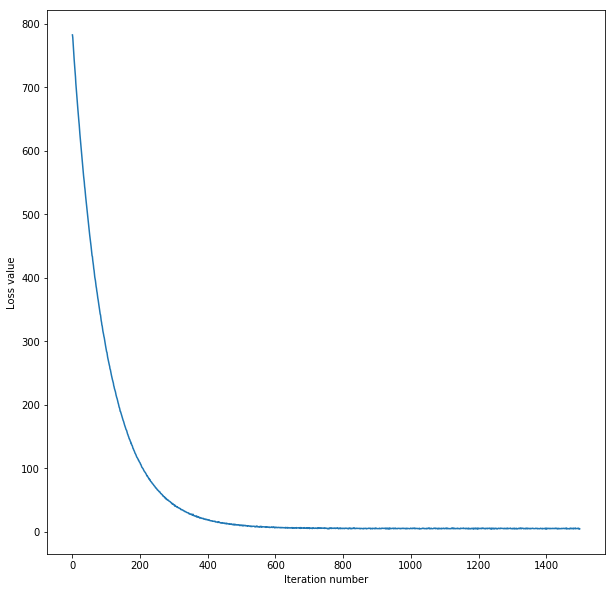

In [13]:
# A useful debugging strategy is to plot the loss as a function of iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.365959
validation accuracy: 0.388000


## 교차 검증
학습률, 규제 강도에 대해 교차 검증을 실시한다. num_iters를 작게 하여 좋은 파라미터 값을 찾은 다음, 좋은 파라미터에 대해 훈련을 더 시킨다.

In [15]:
learning_rates = (np.power(10, np.random.rand(30)) -1) / 9 * 5e-7 + 1e-7
regularization_strengths = np.power(10, np.random.rand(30)) * 5e3 + 2e4

results = {}
best_val = -1   
best_svm = None 
best_params = None

for lr, rs in zip(learning_rates, regularization_strengths):
    svm = LinearSVM()
    svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=200, verbose=False)
    train_acc = np.mean(svm.predict(X_train) == y_train)
    val_acc = np.mean(svm.predict(X_val) == y_val)
    results[(lr, rs)] = (train_acc, val_acc)

    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm
        best_params = (lr, rs)

best_svm.train(X_train, y_train, learning_rate=best_params[0], reg=best_params[1], num_iters=1000, verbose=False)
best_score = np.mean(best_svm.predict(X_val) == y_val)

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_score)
# you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

lr 1.003644e-07 reg 4.882966e+04 train accuracy: 0.326837 val accuracy: 0.323000
lr 1.064697e-07 reg 2.636222e+04 train accuracy: 0.295531 val accuracy: 0.304000
lr 1.066483e-07 reg 3.443978e+04 train accuracy: 0.310306 val accuracy: 0.314000
lr 1.114347e-07 reg 3.130307e+04 train accuracy: 0.304694 val accuracy: 0.308000
lr 1.149242e-07 reg 6.989525e+04 train accuracy: 0.347551 val accuracy: 0.364000
lr 1.208413e-07 reg 5.672292e+04 train accuracy: 0.339082 val accuracy: 0.358000
lr 1.243248e-07 reg 2.991469e+04 train accuracy: 0.309041 val accuracy: 0.305000
lr 1.438288e-07 reg 4.415120e+04 train accuracy: 0.347347 val accuracy: 0.348000
lr 1.481975e-07 reg 3.091676e+04 train accuracy: 0.326898 val accuracy: 0.344000
lr 1.598379e-07 reg 2.919254e+04 train accuracy: 0.343184 val accuracy: 0.341000
lr 1.695054e-07 reg 2.564249e+04 train accuracy: 0.326980 val accuracy: 0.318000
lr 1.827822e-07 reg 2.614745e+04 train accuracy: 0.336367 val accuracy: 0.347000
lr 1.866343e-07 reg 6.391659

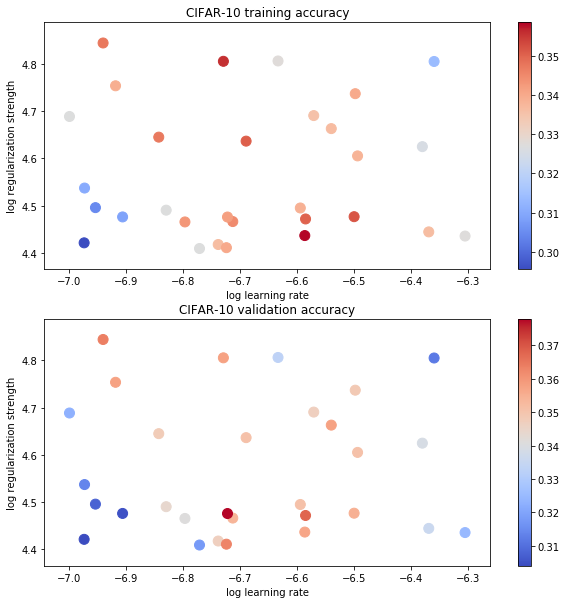

In [16]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.375000


## 학습된 가중치 시각화

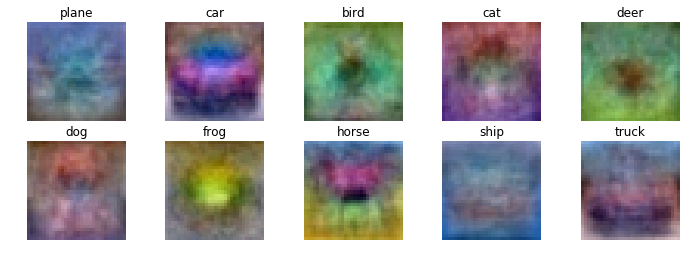

In [18]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

자동차 클래스의 스코어를 산출해내는 가중치는 자동차와 만났을 때 최대 크기로 활성화되도록 학습되었다. 